### From Paper to Code: Understanding and Reproducing "Score-Based Diffusion Models as Principled Priors for Inverse Imaging"
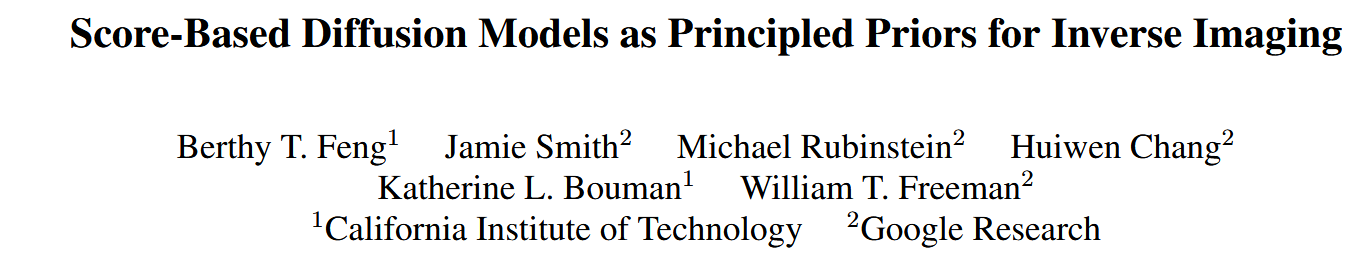
Code: [GitHub Repository](https://github.com/berthyf96/score_prior), 
Corresponding code: ../../../../code/Inv/score_prior-main/demos/2d_posterior_sampling.py

# Paper Reading Notes

## 1. Highlights

To tackle more complex inverse problems that require expressive image priors, this paper proposes using score-based diffusion models as principled priors. It demonstrates the method on challenging tasks—including black hole imaging—showing accurate posterior sampling without heuristic tuning.

## 2. Background

Inverse problems in imaging, such as denoising or deblurring, are ill-posed: many images may explain the same observation. To resolve ambiguity, a *prior* on the image is needed. Classical priors like total variation or Gaussian models are limited in expressiveness.

Bayesian inference offers a clean solution by decomposing the posterior as:

$$
p(x \mid y) \propto p(y \mid x) p(x)
$$

It separates the measurement model (likelihood) from the image prior. But exact inference requires computing $ \log p(x) $ and its gradient, which traditional handcrafted priors support, but deep generative models usually do not.

#### Previous Methods Fail to Sample the True Posterior

Many earlier methods attempt to sample from the posterior $ p(x \mid y) $ using score-based diffusion models. However, they often mistakenly inject the measurement $ y $ at each diffusion step $ x_t $ using the original likelihood $ p(y \mid x_0) $.

This is incorrect. In a diffusion model, $ x_t $ is a noisy version of the clean image $ x_0 $. The correct measurement model at time $ t $ should be:

$$
p(y \mid x_t) = \int p(y \mid x_0) \, p(x_0 \mid x_t) \, dx_0
$$

This integral accounts for the uncertainty in denoising, but is generally intractable. So what do prior methods do?

They often approximate $ p(y \mid x_t) $ by simply evaluating $ p(y \mid \hat{x}_0(x_t)) $, where $ \hat{x}_0(x_t) $ is an estimate of the denoised image (e.g., from the score network). This assumes $ y $ directly depends on $ x_t $, which is not true.

> ❌ Incorrect: $ p(y \mid x_t) \approx p(y \mid x_0) $  
> ✅ Correct (but hard): $ p(y \mid x_t) = \int p(y \mid x_0) \, p(x_0 \mid x_t) \, dx_0 $

This approximation leads to biased posteriors and unreliable uncertainty estimates. The method proposed in this paper avoids this by never modifying the diffusion process, and instead computes the posterior properly via variational inference using the actual log-probability $ \log p_\theta(x) $.


Score-based diffusion models are a promising exception. They define a generative process via denoising, and theoretically allow for exact log-probability and gradient computation. Yet prior works using them in inverse problems often rely on heuristic sampling or tuned parameters, breaking the Bayesian formulation.

> Can we turn score-based diffusion models into true probabilistic priors—ones that allow principled, hyperparameter-free inference?

---
### Review:  Score-based Diffusion Model

Score-based diffusion models are a class of generative models that learn to sample from complex data distributions by reversing a gradual noising process. Instead of modeling the data distribution $ p(x) $ directly, they estimate the score function:

$$
s_\theta(x, t) \approx \nabla_x \log p_t(x)
$$

where $ p_t(x) $ is the distribution of noisy data at time $ t $, and $ s_\theta $ is a neural network trained to approximate its gradient.

#### Forward and Reverse Process

The model defines a forward stochastic differential equation (SDE) that gradually perturbs the data $ x_0 $ into noise:

$$
d x_t = f(x_t, t) dt + g(t) dw
$$

To sample from the data distribution, we reverse this process using either:

- A reverse-time SDE, or
- An equivalent probability flow ODE, which is deterministic.


#### Why Learn the Score?

By learning the score $ \nabla_x \log p_t(x) $, we can use it to simulate the reverse process without needing to know $ p_t(x) $ itself. This approach connects to denoising score matching [Vincent, 2011], and was extended to diffusion models in [Song & Ermon, 2019; 2021].


#### Applications and Relevance

Score-based diffusion models achieve state-of-the-art results in image generation and density estimation. More importantly for inverse problems, they provide access to gradients of the log-probability $ \nabla_x \log p(x) $, which makes them compatible with Bayesian inference frameworks.

> In this blog, we’ll explore how these models work, and how they can be used as expressive priors for solving inverse problems.


#### References

- Song & Ermon. *Generative Modeling by Estimating Gradients of the Data Distribution*. NeurIPS 2019.  
- Song et al. *Score-Based Generative Modeling through Stochastic Differential Equations*. ICLR 2021.  
- Vincent. *A Connection Between Score Matching and Denoising Autoencoders*. Neural Computation, 2011.
---

## 3.Method Overview

This paper transforms a score-based diffusion model into a differentiable image prior $ \log p_\theta(x) $, enabling direct use in Bayesian inference pipelines.

A RealNVP normalizing flow is trained to approximate the posterior $ q_\phi(x) \approx p(x|y) $, guided by:

- A fixed score model defining the prior $ p(x) $
- A task-specific forward model $ \mathcal{A}(x) $
- Self-supervision via observed measurements $ y $


#### 🔁 **Self-Supervised Training**

No ground-truth images are used. The training minimizes:

$$
\mathcal{L}(x) = -\log p(y \mid x) - \log p(x) - H(q_\phi)
$$

- Data term: $ -\log p(y|x) $ comes from a likelihood model defined by the forward operator:
  
  $$
  y = \mathcal{A}(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)
  $$

- Prior term: $ -\log p(x) $ is computed via the score model using a probability flow ODE.

#### Network I/O

| Module     | Input                         | Output                    |
|------------|-------------------------------|---------------------------|
| RealNVP    | $ z \sim \mathcal{N}(0,I) $ | $ x = f_\phi(z) $       |
| ScoreNet   | $ x $ or $ (x_t, t) $     | $ \nabla_x \log p(x) $  |
| Likelihood | $ x $                       | $ \log p(y \mid x) $    |


# Code Reproduction with Explanation: Posterior Sampling with Score-based Priors, 2D Example

To set up the environment, first 
```bash
bash conda.sh
```

This script installs:

- `jax==0.6.0`
- `flax==0.10.6`

Note: Since the ETH codebase now supports `numpy > 1.23.5`, version 1.26.4 is fully compatible, so finally make sure `numpy==1.26.4`

In [1]:
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/Inv/score_prior-main"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import diffrax
import flax
import IPython.display as ipd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import seaborn as sns
from score_flow import sde_lib
import tensorflow_probability.substrates.jax as tfp

import probability_flow
from posterior_sampling import realnvp_model
from posterior_sampling import model_utils as mutils

sns.set(font='serif', font_scale=1.5)
tfd = tfp.distributions

Current working directory: /home/xqgao/2025/MIT/Awesome-Computational-Imaging/chapters/Chapter12_ScoreDiffusion
Appending path: /home/xqgao/2025/MIT/code/Inv/score_prior-main


2025-05-01 14:20:40.635463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Ground-truth posterior

In this example, we will work with a mixture-of-Gaussians prior and a linear forward model. The resulting posterior is also a mixture-of-Gaussians.

Prior: $\mathbf{x}\sim\sum_{k=1}^K\mathcal{N}(\mathbf{\mu}_k,\beta_k^2\mathbf{I}_2)$

Likelihood: $y=\mathbf{a^\intercal x}+\eta,\quad\eta\sim\mathcal{N}(0,\sigma^2)$

In [2]:
"""
The prior is a mixture-of-Gaussians with K Gaussian components.
Each component has a weight, mean, and diagonal covariance with uniform scale.
You can change these parameters to see how the posterior changes.
"""
means = np.array(
    [[-0.5, -0.5],
    [0.5, 0.5]]
).astype(np.float32)
betas = np.array([0.1, 0.1], dtype=np.float32)
weights = np.array([0.5, 0.5], dtype=np.float32)
K = len(weights)
prior = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=means,
        scale_diag=jnp.stack([jnp.ones(2) * b for b in betas], axis=0))
)

In [3]:
"""
The measurement is a linear projection of x with Gaussian noise.
This means p(y|x) is also Gaussian.
"""
sigma = 0.2  # std. dev. of measurement noise
a = np.array([-2., 1.7], dtype=np.float32)  # forward operator
y = 0.3  # observation

likelihood = lambda x: tfd.Normal(loc=jnp.dot(a, x), scale=sigma)

def prob_y(y):
  stds = jnp.sqrt(betas2 * jnp.dot(a, a) + sigma2)
  dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=jnp.einsum('j,bj->b', a, means)[:, None],
        scale_diag=stds[:, None]))
  return dist.prob(y)

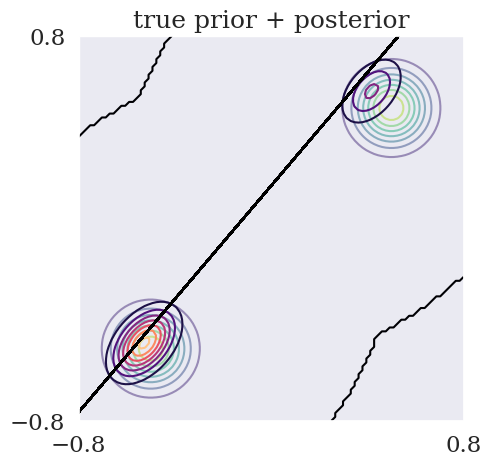

In [4]:
"""
With the prior and likelihood defined, we also know the posterior.
"""
# Posterior p(x|y)
@jax.vmap
def posterior_prob(x, y):
  py = prob_y(y)
  px = prior.prob(x)
  return likelihood(x).prob(y) * px / py

# Parameters for plotting
x1_range = (-0.8, 0.8)
x2_range = (-0.8, 0.8)

# Domain
x1_grid, x2_grid = np.meshgrid(
    np.linspace(*x1_range, 100), np.linspace(*x2_range, 100))
x1_flattened = x1_grid.reshape(-1)
x2_flattened = x2_grid.reshape(-1)
X = np.stack([x1_flattened, x2_flattened], axis=-1)

# True prior PDF
prior_grid = prior.prob(X).reshape(100, 100)

# True posterior PDF
Y = np.full(X.shape[0], y).astype(np.float32)
posterior_grid = posterior_prob(X, Y).reshape(100, 100)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
ax.set_xlim(*x1_range); ax.set_ylim(*x2_range)
ax.set_xticks(x1_range); ax.set_yticks(x2_range)
ax.contour(x1_grid, x2_grid, prior_grid, cmap='viridis', alpha=0.5)
ax.contour(x1_grid, x2_grid, posterior_grid, cmap='magma')
ax.plot(x1_flattened, y / a[1] - x1_flattened * (a[0] / a[1]),
         linestyle='--', c='black')
plt.title('true prior + posterior')
plt.show()

## DPI Posterior Sampling

The DPI optimization objective is
\begin{align*}
\phi^* &= \arg\min_\phi D_{\text{KL}}(q_\phi\lVert p(\cdot\mid y) \\
&= \arg\min_\phi \mathbb{E}_{\mathbf{x}\sim q_\phi}[-\log p(y\mid\mathbf{x})-\log p(\mathbf{x})+\log q_\phi(\mathbf{x})],
\end{align*}
where $\phi$ are the parameters of a RealNVP normalizing flow. Of course, we could directly use the known prior $p(\mathbf{x})$. However, for demonstration purposes, we will assume that we only have access to the time-dependent score function $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, where

\begin{align*}
p_t(\mathbf{x})=\sum_{k=1}^K\mathcal{N}(\mathbf{x}; \alpha(t)\mu_k, \alpha(t)^2\beta_k^2+\beta(t)^2).
\end{align*}
$\alpha(t)$ and $\beta(t)$ are scalars determined by the diffusion SDE. To calculate $\log p(\mathbf{x})$ with only the score function, we can use the probability flow ODE as proposed in the paper.

In [5]:
"""
The SDE dictates how the prior distribution changes over diffusion time
and hence the probability flow ODE used to evaluate logp(x).
"""
sde = sde_lib.VPSDE()
t0_eps = 1e-12  # smallest time for numerical stability

def marginal_dist_params(t: float):
  """The mean coefficient and std. dev. of the marginal distribution at t."""
  all_ones = jnp.ones((1, 1))
  t_batch = jnp.ones(1) * t
  mean, std = sde.marginal_prob(all_ones, t_batch)
  alpha_t = mean[0][0]
  beta_t = std[0]
  return alpha_t, beta_t

def score_fn(x, t_batch):
  def _unnormalized_log_prob(data, t):
    alpha_t, beta_t = marginal_dist_params(t)
    var_t = alpha_t2 * betas2 + beta_t2
    means_t = alpha_t * means
    norm2 = jnp.linalg.norm(data - means_t, axis=-1)2
    return jax.scipy.special.logsumexp(-0.5 * norm2 / var_t)
  return jax.vmap(jax.grad(lambda xi, ti: _unnormalized_log_prob(xi, ti)))(x, t_batch)

# `prob_flow` is a wrapper for the probability flow ODE.
prob_flow = probability_flow.ProbabilityFlow(
  sde=sde,
  score_fn=score_fn,
  solver=diffrax.Dopri5(),
  stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5),
  adjoint=diffrax.RecursiveCheckpointAdjoint(),
  n_trace_estimates=-1)

Here we set up the RealNVP that we wish to optimize.

A normalizing flow is a type of generative model that learns a complex data distribution by transforming a simple distribution (like a standard Gaussian) through a sequence of invertible and differentiable functions. Unlike implicit models (e.g., GANs), flows enable exact likelihood computation using the change-of-variables formula:
$$
\log p(x) = \log p(z) + \log \left| \det \left( \frac{\partial z}{\partial x} \right) \right|, \quad z = f^{-1}(x)
$$

RealNVP (Real-valued Non-Volume Preserving flow) is a popular flow model that uses affine coupling layers, where only part of the input is transformed at each step, enabling tractable and stable Jacobian computation.

In [6]:
batch_size = 2560
learning_rate = 1e-5

dim = 2  # data dimensionality (2 in this case)
n_flow = 8  # number flow layers (each layer has 2 affine-coupling layers)

orders, reverse_orders = realnvp_model.get_orders(dim, n_flow)
model = realnvp_model.RealNVP(
    out_dim=dim,
    n_flow=n_flow,
    orders=orders,
    reverse_orders=reverse_orders,
    seqfrac=1/128,
    include_softplus=False,
    init_softplus_log_scale=1,
    train=True)

# Initialize params and model state.
init_rng = jax.random.PRNGKey(42)
z = jax.random.normal(init_rng, (batch_size, dim))
variables = model.init(init_rng, z, reverse=True)
init_model_state, init_params = flax.core.pop(variables, 'params')

# Initialize optimizer.
optimizer = optax.adam(learning_rate=learning_rate)

# Initialize training state.
opt_state = optimizer.init(init_params)
state = mutils.State(
    step=0,
    opt_state=opt_state,
    params=init_params,
    model_state=init_model_state,
    entropy_weight=1,
    rng=jax.random.PRNGKey(0)
)

RealNVP flow is trained in a self-supervised way using only measurements $ y $, without ground-truth images.

```python
def data_loss_fn(x):
    return -likelihood(x).log_prob(Y)
```   
Here, `likelihood(x)` defines the forward model $ \mathcal{A}(x) $ and noise model, modeling $ p(y|x) $.  
The loss enforces that the generated sample $ x $ is consistent with the observed data $ y $.

No labels or true images are used — supervision comes purely from physics via $ \mathcal{A}(x) $.

In [7]:
"""
Here we define the optimization objective function and update step for the RealNVP.
"""
@jax.vmap
def data_loss_fn(x):
  return -likelihood(x).log_prob(Y)

def prior_loss_fn(rng, x):
  return -prob_flow.logp_fn(rng, x, t0=t0_eps, t1=sde.T, dt0=None)

def get_sampling_fn(model, params, states, train=False):
  def sample_fn(rng, shape):
    # Sample latent.
    z = jax.random.normal(rng, shape)

    variables = {'params': params, states}
    if train:
      (samples, logdet), new_states = model.apply(
          variables, z, reverse=True, mutable=list(states.keys()))
    else:
      samples, logdet = model.apply(variables, z, reverse=True, mutable=False)
      new_states = states
    return (samples, logdet), new_states
  return sample_fn

def loss_fn(rng, params, model_state, lambda_entropy):
  sample_fn = get_sampling_fn(model, params, model_state, train=True)

  # Sample from the current state of the RealNVP.
  rng, step_rng = jax.random.split(rng)
  (samples, logdet), new_model_state = sample_fn(step_rng, (batch_size, dim))

  # Compute loss across this batch of samples.
  loss_data = data_loss_fn(samples)
  rng, step_rng = jax.random.split(rng)
  loss_prior = prior_loss_fn(step_rng, samples)
  loss_entropy = -lambda_entropy * logdet

  loss_data = jnp.mean(loss_data)
  loss_prior = jnp.mean(loss_prior)
  loss_entropy = jnp.mean(loss_entropy)
  loss = loss_data + loss_prior + loss_entropy

  return loss, (new_model_state, loss_data, loss_prior, loss_entropy, samples)

def step_fn(rng, state):
  val_and_grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)

  params = state.params
  model_state = state.model_state
  opt_state = state.opt_state
  (loss, (new_model_state, loss_data, loss_prior, loss_entropy, samples)), grad = val_and_grad_fn(
      rng, params, model_state, lambda_entropy=state.entropy_weight)

  # Apply updates.
  updates, new_opt_state = optimizer.update(grad, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  step = state.step + 1
  new_state = state.replace(
      step=step,
      opt_state=new_opt_state,
      params=new_params,
      model_state=new_model_state,
  )

  return new_state, (loss, loss_data, loss_prior, loss_entropy), samples

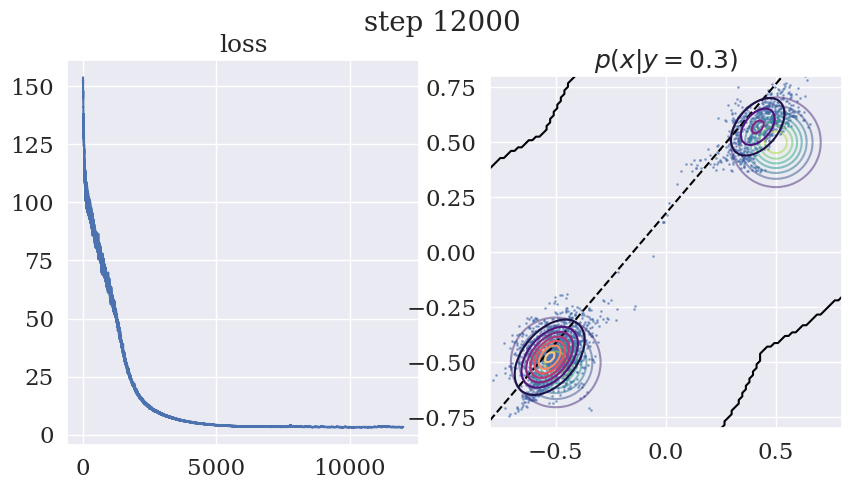

In [8]:
"""
We iteratively sample from the RealNVP, estimate its KL divergence to the target posterior,
and update the RealNVP parameters with gradients to minimize the KL divergence.
"""
losses_total, losses_data, losses_prior, losses_entropy = [], [], [], []
train_step = jax.jit(step_fn)

init_step = state.step
rng = state.rng
for step in range(init_step, 12001):
  rng, step_rng = jax.random.split(rng)
  state, (loss, loss_data, loss_prior, loss_entropy), samples = train_step(
      step_rng, state)

  # Update losses.
  losses_total.append(loss)
  losses_data.append(loss_data)
  losses_prior.append(loss_prior)
  losses_entropy.append(loss_entropy)

  if step % 10 == 0:
    ipd.clear_output(wait=True)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'step {step}', fontsize=20)

    ax = axs[0]
    ax.plot(losses_total); ax.set_title('loss', fontsize=18)

    ax = axs[1]
    ax.set_aspect('equal')
    ax.set_xlim(*x1_range); ax.set_ylim(*x2_range)
    ax.plot(x1_flattened, y / a[1] - x1_flattened * (a[0] / a[1]),
            linestyle='--', c='black')
    ax.contour(x1_grid, x2_grid, prior_grid, alpha=0.5, cmap='viridis')
    ax.contour(x1_grid, x2_grid, posterior_grid, cmap='magma')
    ax.scatter(
        samples[:, 0], samples[:, 1],
        s=1, alpha=0.5, label='DPI samples')
    plt.title(f'$p(x|y={y})$')
    plt.show()

## **Results Analysis**

The figure shows the estimated posterior $ p(x \mid y = 0.3) $ in a 2D toy problem. The black dashed line represents the likelihood constraint from the forward model $ \mathcal{A}(x) = y $. The solid black contours denote the prior $ p(x) $, and the colored contours represent the learned posterior $ q_\phi(x) $. Samples from the RealNVP model are overlaid as points.

This visualization demonstrates how DPI captures uncertainty by producing a bimodal posterior consistent with both the observation and prior.

The prior and posterior do not fully overlap because the prior encodes general image plausibility, while the posterior incorporates both prior and data. It is not necessary for the two to coincide; rather, the posterior should align with high-probability regions of the prior **along the likelihood manifold**.

Shape alignment and support overlap are sufficient, as exact matching is neither expected nor required.